# Cancer Classification Using Gene Expression
Data: Golub et al, 1999.


## About the Data
gene expression data from patients diagnosed with acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL).
- 7129 genes in cells from bone marrow and peripheral blood
-  AML and ALL have similar disease progression but differ in treatments, therefore distinction and classification is important.

## Objective
Classifying the two cancers, i.e. AML and ALL, using this gene expression data (**a binary classification problem**).
- Evaluation method: k-fold cross-validation
- Evaluation metric: accuracy

In [1]:
# Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

In [2]:
# Readinh datasets
trainData = pd.read_csv("data_set_ALL_AML_train.csv")
testData = pd.read_csv("data_set_ALL_AML_independent.csv")

print(trainData.shape)
print(testData.shape)

(7129, 78)
(7129, 70)


The training dataset has 78 columns (i.e. samples) whereas the testing has 70 columns. Rows correspond to genes.

In [3]:
trainData.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [4]:
# Cleaning data

# Removing columns with "call.x"
# From training data
colsToRemoveTrain = [cols for cols in trainData if 'call' in cols]
trainData = trainData.drop(colsToRemoveTrain, axis=1)
print(trainData.columns)

# Removing from test data
colsToRemoveTest = [cols for cols in testData if 'call' in cols]
testData = testData.drop(colsToRemoveTest, axis=1)
print(testData.columns)

Index(['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '34', '35',
       '36', '37', '38', '28', '29', '30', '31', '32', '33'],
      dtype='object')
Index(['Gene Description', 'Gene Accession Number', '39', '40', '42', '47',
       '48', '49', '41', '43', '44', '45', '46', '70', '71', '72', '68', '69',
       '67', '55', '56', '59', '52', '53', '51', '50', '54', '57', '58', '60',
       '61', '65', '66', '63', '64', '62'],
      dtype='object')


In [5]:
# Since we are classifying patients (i.e. AML versus ALL) and predicting using gene expression,
# We transpose the data
X_train = trainData.transpose()
X_test = testData.transpose()

# Since both gene description and accession are now column-wise,
# setting accessing as columns and removing the gene description
X_train.columns = X_train.iloc[1]
X_train = X_train.iloc[2:].reset_index(drop=True)

X_test.columns = X_test.iloc[1]
X_test = X_test.iloc[2:].reset_index(drop=True)

In [6]:
# Reading in response variable
yData = pd.read_csv("actual.csv")
print(yData.head())
print(yData.shape)

   patient cancer
0        1    ALL
1        2    ALL
2        3    ALL
3        4    ALL
4        5    ALL
(72, 2)


In [7]:
#merging X and y
X_train.shape[0]+X_test.shape[0]

72

Though a test and train data was separated and given, they were merged to perform a complete k-fold cross validation.

In [8]:
# Merging X data by row
mergedX = pd.concat([X_train, X_test], ignore_index=True, axis=0)

# Merging X and Y
mergedXY = pd.concat([mergedX, yData], axis=1)
mergedXY.head()

affymetricProbeCols = [cols for cols in mergedXY if 'AFFX' in cols]
mergedXY = mergedXY.drop(affymetricProbeCols, axis=1)
mergedXY

,hum_alu_at,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,...,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,patient,cancer
0,15091,151,72,281,36,-299,57,186,1647,137,...,-125,389,-37,793,329,36,191,-37,1,ALL
1,11038,263,21,250,43,-103,169,219,2043,188,...,-36,442,-17,782,295,11,76,-14,2,ALL
2,16692,88,-27,358,42,142,359,237,1997,91,...,33,168,52,1138,777,41,228,-41,3,ALL
3,15763,484,61,118,39,-11,274,245,2128,-82,...,218,174,-110,627,170,-50,126,-91,4,ALL
4,18128,118,16,197,39,237,311,186,1608,204,...,57,504,-26,250,314,14,56,-25,5,ALL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,22818,316,0,105,104,-76,38,261,1397,60,...,-34,239,-78,707,354,-22,260,5,68,ALL
68,39323,228,36,106,113,19,141,165,1030,73,...,36,358,2,423,41,0,1777,-49,69,ALL
69,15689,395,73,334,73,417,259,359,2656,318,...,-27,548,-39,809,445,-2,210,16,70,ALL
70,41570,311,-56,235,46,845,168,517,3570,92,...,-121,197,-108,466,349,0,284,-73,71,ALL


<Axes: >

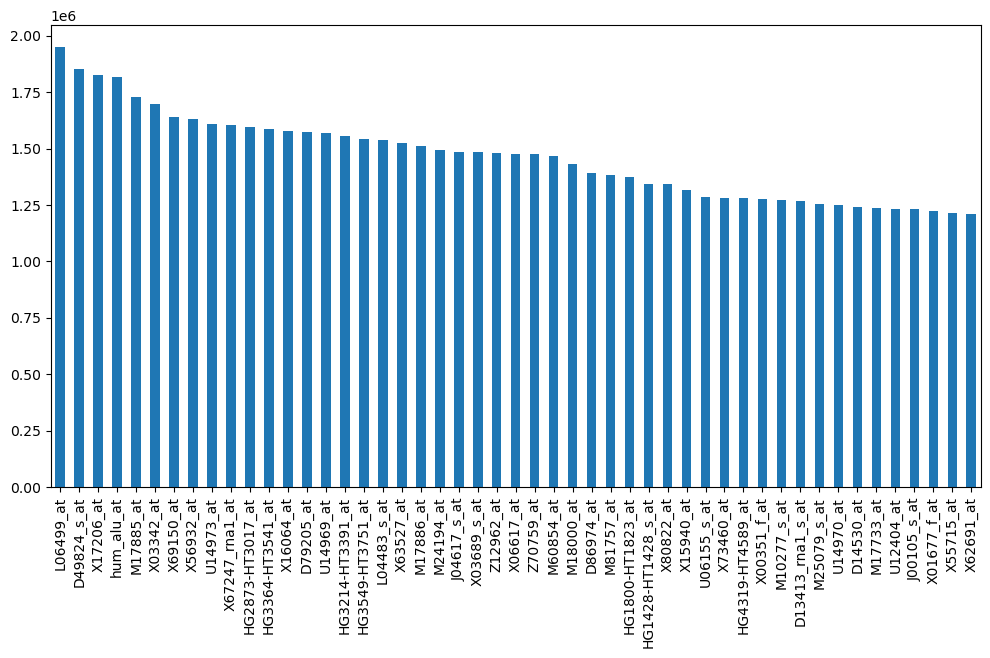

In [9]:
colSum = mergedXY.sum(axis=0)
colSum = colSum[0:len(colSum)-2]
colSum.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(12, 6))  # Increase width for better label spacing

colSum[0:49].plot(kind='bar')

In [10]:
# Normalizing data
zscaler = StandardScaler()
mergedXY_norm = zscaler.fit_transform(mergedXY.iloc[:, :-2])
mergedXY_norm = pd.DataFrame(mergedXY_norm, columns=mergedXY.columns[:-2])
mergedXY_norm['cancer'] = mergedXY['cancer']
mergedXY_norm

,hum_alu_at,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer
0,-0.936280,-0.675607,0.622599,-0.041155,-0.177982,-1.599568,-0.869057,0.059753,-0.316766,-0.046424,...,-0.518375,-1.304810,0.019140,-0.064488,0.027771,0.122186,0.593119,-0.391378,-0.161117,ALL
1,-1.311323,-0.079861,-0.148198,-0.124816,-0.030444,-0.631098,-0.249914,0.350683,0.391598,0.308722,...,0.555431,-0.279396,0.160143,0.322438,0.003223,-0.043618,0.032103,-0.576990,0.415146,ALL
2,-0.788133,-1.010714,-0.873653,0.166646,-0.051521,0.579490,0.800417,0.509372,0.309313,-0.366752,...,1.747818,0.515587,-0.568816,1.657332,0.797680,2.306901,0.705322,-0.331659,-0.261337,ALL
3,-0.874097,1.095673,0.456348,-0.481047,-0.114751,-0.176510,0.330532,0.579901,0.543645,-1.571465,...,0.548844,2.647065,-0.552853,-1.476766,-0.342677,-0.653193,-1.336776,-0.496289,-1.514082,ALL
4,-0.655253,-0.851139,-0.223766,-0.267848,-0.114751,1.048901,0.535070,0.059753,-0.386529,0.420141,...,-0.063819,0.792103,0.325090,0.148322,-1.183998,0.049037,0.099424,-0.609271,0.139542,ALL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-0.221267,0.202054,-0.465585,-0.516130,1.255240,-0.497686,-0.974090,0.720958,-0.763966,-0.582626,...,-0.449204,-0.256353,-0.379925,-0.857685,-0.164148,0.244101,-0.708438,-0.280010,0.891189,ALL
68,1.306015,-0.266032,0.078507,-0.513431,1.444931,-0.028274,-0.404700,-0.125384,-1.420454,-0.492098,...,-1.223267,0.550152,-0.063333,0.690017,-0.797928,-1.282274,-0.214744,2.168460,-0.461776,ALL
69,-0.880945,0.622268,0.637712,0.101877,0.601860,1.938313,0.247611,1.584931,1.488131,1.213997,...,-0.096758,-0.175703,0.442150,-0.103180,0.063477,0.687871,-0.259626,-0.360711,1.166793,ALL
70,1.513940,0.175458,-1.311949,-0.165297,0.032786,4.053135,-0.255442,2.977868,3.123092,-0.359789,...,1.556772,-1.258724,-0.491663,-1.438074,-0.701968,0.219718,-0.214744,-0.241274,-1.063094,ALL


In [11]:
# Splitting data into train and test
#X_train, X_test, y_train, y_test = train_test_split(mergedXY_norm.iloc[:,:-1],
#                                                    mergedXY_norm['cancer'],
#                                                    test_size=0.2, 
#                                                    random_state=42)
#print(X_train.shape)
#print(X_test.shape)
#print(y_train.shape)
#print(y_test.shape)

## Spot Checking
I will be spot-checking the following machine learning algorithms:
1. Random Forest
2. Logistic Regression
3. K-Nearest Neighbours (KNN)
4. Linear Discriminant Analysis (LDA)
5. Support vector machine (SVM)
6. Classification And Regression Trees (CART)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import KFold, cross_val_score
from matplotlib import pyplot
import random

In [99]:
# Splitting features versus target variables
X = mergedXY_norm.iloc[:,0:mergedXY_norm.shape[1]-2]
y = mergedXY_norm['cancer']

In [14]:
# Define models
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('Random Forest', RandomForestClassifier()))

In [15]:
# Performing 10-fold cross validation on all models
# And calculating accuracy scores
random.seed()

results = []
names = []

for name, model in models:
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kfold)
    results.append(scores)
    names.append(name)
    print(f"Average accuracy for {name}:, {scores.mean()}")

Average accuracy for LR:, 0.5232142857142856
Average accuracy for LDA:, 0.7767857142857142
Average accuracy for KNN:, 0.6928571428571428
Average accuracy for CART:, 0.6678571428571428
Average accuracy for SVM:, 0.7642857142857143
Average accuracy for Random Forest:, 0.7625


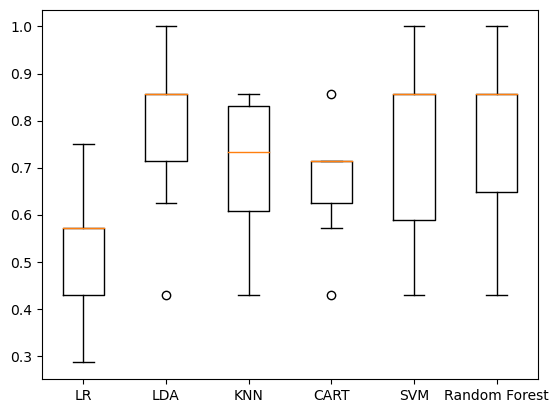

In [16]:
fig = pyplot.figure()
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

From the boxplot, **LDA**, **SVM** and **Random Forest** does the best and very similar to each other.
- Golub et al 1999 paper used KNN and therefore, this was also performed in depth below.

## Random Forest Classification of AML and ALL
Performing classification of the two cancer types using random forest and the **entire dataset**.
- Evaluation method: k-fold cross-validation
- Evaluation metric: accuracy

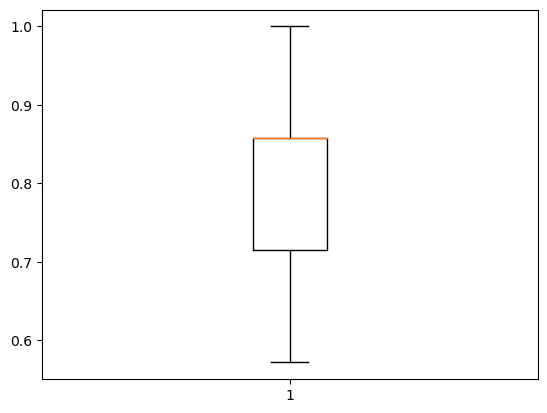

Mean result: 69.79166666666664
Std.Dev of results: 17.938184160157313


In [17]:
kfold_randfor = KFold(n_splits = 10, shuffle=True, random_state = 5)

randomForest = RandomForestClassifier()
results_randfor = cross_val_score(randomForest, X, y, cv=kfold_randfor)

fig = pyplot.figure()
ax = fig.add_subplot(111)
pyplot.boxplot(results_randfor)
pyplot.show()

print('Mean result:', np.array(results).mean()*100)
print('Std.Dev of results:', np.array(results).std()*100)

### Perform Feature Selection
Feature selection was performed in order to:
- Reduce dimensionality
- Prevent overfitting the data
- Tune and improve model perform
#### Using sklearn
Selecting top 50 features using sklearn.

In [18]:
randomForest.fit(X, y)
featureImportance = randomForest.feature_importances_

# Select the top N most important features
N = 50  # Select top 50 genes
topFeatures = np.argsort(featureImportance)[::-1][:N]
topFeatures
X_selected = X.iloc[:, topFeatures]
X_selected

,U46751_at,M84526_at,M80254_at,U77948_at,M31551_s_at,L41559_at,U73737_at,M20203_s_at,U15009_at,Z11697_at,...,X71490_at,Y00451_s_at,X85116_rna1_s_at,M86917_at,X84908_at,M27783_s_at,L20321_at,D12676_at,U73514_at,M26602_at
0,-0.576492,-0.563074,-0.978229,0.349694,-0.180393,-0.786946,-0.083683,-0.352243,-0.401875,-0.606034,...,-0.214665,-0.040510,-0.739110,-0.430744,1.492116,-0.379765,0.219471,0.331535,-1.565490,-0.353522
1,-0.539663,-0.500850,-0.080158,0.577865,-0.156103,-0.811211,-0.222891,-0.366585,0.187299,0.247864,...,0.449465,-0.283267,-0.731214,-1.059194,-0.229753,-0.404200,0.127385,-2.366872,1.001482,-0.345699
2,-0.486466,-0.595042,-0.818673,0.463779,-0.169505,-0.236926,-0.183627,-0.348348,0.406796,-0.773388,...,0.711308,-0.605735,-0.942160,0.347338,0.754172,-0.361439,-0.019952,-0.163439,-1.442210,-0.334164
3,-0.529661,-0.587050,-1.083080,1.400386,-0.443393,-0.778857,0.698021,-0.343213,0.618591,-0.718042,...,-0.081363,-0.138337,-0.697372,0.327387,-0.438837,-0.345382,0.735151,0.219767,-1.506589,-0.356330
4,-0.305505,-0.399521,0.056604,1.063649,-0.000314,0.305005,1.408337,-0.347640,1.731476,-0.490073,...,0.846991,0.579064,-0.545085,-0.141457,2.574433,-0.320249,2.337443,0.730708,1.294616,-0.341988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-0.208659,0.849814,-0.139421,-1.166541,-0.197982,-0.188395,-0.779721,0.149551,-0.956393,1.385077,...,-0.036136,-0.214425,0.593121,-1.268678,-0.943099,0.307377,0.256305,0.187833,-0.027224,-0.326742
68,-0.673793,-0.536243,0.936440,-0.312739,-0.128463,-0.738414,-0.387084,-0.324622,0.441453,-0.281869,...,-0.759776,-0.518778,-0.115297,-0.690104,-0.512632,-0.354807,-0.443546,-0.323108,1.239824,-0.320424
69,-0.084077,1.779465,-0.745733,-0.307218,-0.102499,0.329270,-0.426348,0.019588,0.014013,1.956978,...,2.520409,0.046448,0.056168,-0.490596,0.458994,0.009272,0.090551,0.794575,0.435762,-0.366159
70,0.349230,0.289797,-1.156020,0.029518,-0.286766,0.410155,-0.115808,-0.384646,-1.225950,-0.536194,...,1.549207,-0.120221,-0.044229,0.048076,1.344527,-0.325659,-0.701387,0.331535,-1.383309,-0.300966


#### Using T-test
What is a t-test and why is it used for feature selection?
- running a t-test to compare the means of the two cancer types.
- Here we are comparing the mean expression between the two genes to see if they differ significantly.
- We therefore select genes lying below a significance threshold (alpha), here, 0.05
    - If the p-value is below 0.05 we reject the null hypothesis that states there is no difference in mean between the two groups.
- By selecting only genes with significant expression difference between the two cancers, we can only use those genes to discriminate between the classes since they would account for most of the variation in the two cancers.
- This additionally helps us reduce dimensionality reducing computation resources (eg:time)

In [19]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection

In [20]:
# Splitting data into the two cancer classes
ALL = X[mergedXY_norm['cancer'] == "ALL"]
AML = X[mergedXY_norm['cancer'] == "AML"]
print(ALL.shape)
print(AML.shape)

(47, 7070)
(25, 7070)


In [21]:
AML

,hum_alu_at,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,...,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at
27,-0.785912,0.244607,0.078507,-0.246258,-0.704902,0.767255,-0.747440,1.241105,1.051664,-0.088206,...,-0.739353,0.905590,1.121980,-0.498305,-0.645969,-0.451413,0.119268,1.234050,-0.484032,-0.158959
28,1.876860,1.037162,-0.465585,0.120768,-1.084284,-0.927568,-0.576070,0.703325,-0.343598,-0.770644,...,-0.837541,-0.880926,-1.094805,-0.383090,-0.563495,0.883480,-0.063725,-0.043618,0.413593,1.814989
29,-0.124383,-1.212842,-0.994562,-0.599790,-0.114751,2.032195,-0.708743,-0.636715,0.257438,0.698687,...,-0.804812,0.627450,3.243242,0.907318,0.277203,-1.051148,1.143580,0.185582,0.368712,-0.302607
30,-0.726412,-0.154329,0.078507,0.085684,-0.683825,-0.828745,-0.448925,-0.425130,0.393386,0.127667,...,-0.834424,-0.313948,-0.600722,-0.233310,-0.127184,1.328445,2.125493,0.000271,0.054543,4.453914
31,-0.536994,0.420140,-0.722517,-0.599790,0.138170,0.312667,-0.570542,-0.733692,0.001640,-0.492098,...,-1.001188,-0.773949,1.490895,1.310571,-0.137825,-1.515459,1.755044,1.575411,0.256509,3.367678
32,-0.678387,-0.468160,0.123848,-0.221970,0.559706,-0.379098,-0.200162,-1.156863,0.627719,1.367198,...,-0.778317,-0.025110,0.285333,-0.129617,0.508661,1.463869,0.460705,-0.121644,0.278950,0.368826
33,0.077990,0.212692,-0.450471,-0.521528,-2.222431,0.070549,-0.183578,-1.165679,-1.517049,-0.568698,...,-0.957549,-0.025110,-0.580959,0.757539,-0.278828,0.399823,-1.119281,-1.233508,-0.080101,3.309573
34,-1.223878,0.553119,-0.450471,-0.154502,0.580783,1.740666,-0.653463,-0.054855,-0.102111,1.555216,...,-1.122754,0.531171,0.226043,0.861232,0.239957,1.289752,-0.097199,-0.375227,-0.416710,-0.100854
35,-0.157418,1.106311,-0.813199,-0.203079,-0.114751,-0.191333,-0.520789,0.932543,0.205563,-0.763681,...,-0.846893,-1.490695,-0.251570,0.792103,-0.443775,0.225707,-0.429711,0.278237,-0.798201,-0.484991
36,-0.667468,0.585034,0.380780,0.293486,3.109998,-0.275333,-0.985146,-0.583819,-0.647694,-0.499062,...,-0.374655,1.846988,0.888114,-0.037445,0.136200,0.612632,0.869091,-0.097261,0.660440,-0.218677


In [22]:
resultsTTest = []

for gene in ALL.columns:
    t_stat, p_val = ttest_ind(ALL[gene], AML[gene], equal_var=False)  # Perform t-test
    resultsTTest.append((gene, t_stat, p_val))
    
dfResults = pd.DataFrame(resultsTTest, columns=['Gene Accession Number', 'T_Value', 'P_Value'])

# correcting for multiple testing
sig, adj_p_values = fdrcorrection(dfResults['P_Value'])
sigGenes = dfResults[sig & (adj_p_values < 0.05)]
sigGenes = sigGenes.sort_values(by='P_Value')
sigGenes

,Gene Accession Number,T_Value,P_Value
3242,U49248_at,5.074976,0.000004
4476,X74262_at,4.800367,0.000009
5195,D38073_at,4.759275,0.000010
5293,M69181_at,4.597115,0.000022
1247,L13278_at,4.549869,0.000022
4137,X17042_at,-4.746617,0.000037
320,D32050_at,4.357197,0.000045
473,D63874_at,4.306755,0.000054
4602,X81372_at,4.294243,0.000057
2582,U05237_at,4.257756,0.000063


In [23]:
print(f"Using t-test, a total of {sigGenes.shape[0]} genes, i.e. features were selected (after multiple testing correction).")

Using t-test, a total of 34 genes, i.e. features were selected (after multiple testing correction).


### Utilizing only these 34 genes in random forest classification model

In [24]:
featureSelectGenes = sigGenes['Gene Accession Number'].tolist()
mergedXY_selected = mergedXY_norm[featureSelectGenes + ["cancer"]]
mergedXY_selected

,U49248_at,X74262_at,D38073_at,M69181_at,L13278_at,X17042_at,D32050_at,D63874_at,X81372_at,U05237_at,...,U20998_at,X84194_at,Z15115_at,X90872_at,X66171_at,U50136_rna1_at,D63391_at,U26266_s_at,X16546_at,cancer
0,0.824753,0.596117,0.796240,1.589570,1.139483,-1.031073,1.438772,-0.755489,1.313778,0.693934,...,0.619675,0.265865,2.477027,-0.054595,0.273985,-0.238654,0.947451,0.015225,-0.614065,ALL
1,-0.021115,0.361579,-0.294445,0.354606,-0.532753,0.027024,-0.757406,1.535736,0.740989,0.780348,...,0.444853,-1.316327,-0.527349,-0.045368,-1.582510,-0.310930,-1.840334,0.011852,-0.362941,ALL
2,-0.409757,1.655280,1.867749,1.718141,1.191095,-0.954044,1.330509,1.711603,1.186492,1.060607,...,1.786696,0.533278,0.024343,-0.133028,-1.485496,0.080760,1.611981,0.548158,-0.517336,ALL
3,-0.249728,0.195656,0.043548,-0.887125,0.086594,-0.961780,1.220038,0.584258,0.422773,-0.018392,...,0.310553,1.424653,0.550708,-0.345258,-0.387474,-0.450820,-0.595556,0.470579,-0.656849,ALL
4,0.813323,0.593622,0.690767,-0.860058,1.149805,1.481222,1.326090,0.922059,0.577335,0.567817,...,1.250654,1.836915,0.165720,1.634017,-0.056745,-0.467140,0.535766,0.268200,0.312303,ALL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2.345030,-0.847289,-0.572510,-0.795772,-1.028230,0.551076,-1.124173,-0.671581,-0.013638,-1.197817,...,-1.061392,-1.260616,-0.912337,-1.600183,-1.053343,1.189385,0.286162,0.278319,0.111404,ALL
68,0.481834,0.234330,0.391129,0.720020,-0.161145,-0.011652,-1.245692,-0.666008,-0.468232,-1.097391,...,0.160044,-0.592084,-0.409919,0.079202,0.562822,-0.645499,0.603840,0.315421,-0.777761,ALL
69,-0.032546,-0.105001,-0.037954,-0.721336,0.045304,0.580728,2.225330,-0.446484,0.122741,-0.072108,...,-0.198861,-0.012690,-0.675634,-0.455987,1.067736,1.367744,-0.832193,-0.747071,1.076836,ALL
70,0.573279,-0.436848,-0.126647,-0.491260,0.313688,0.945889,1.980083,0.205277,4.204999,2.840255,...,-0.578606,2.694864,0.197495,-0.686672,-1.884577,2.169777,-0.621489,-0.413145,0.297422,ALL


In [25]:
X_selected = mergedXY_selected.iloc[:,0:mergedXY_selected.shape[1]-1]
y_selected = mergedXY_selected[['cancer']]

/Users/maitreepatel/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/maitreepatel/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/maitreepatel/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/maitreepatel/anaconda3/lib/python3.11/site-packages/sklearn/model_selection

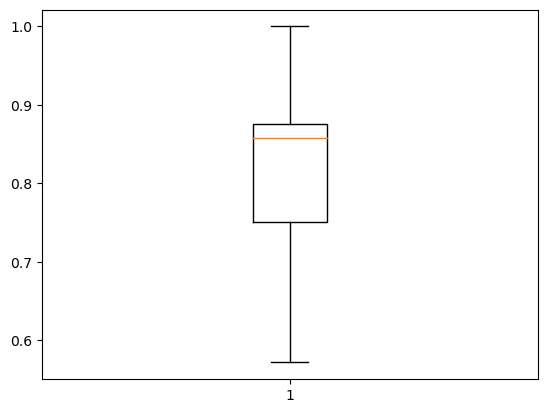

Mean result: 81.78571428571428
Std.Dev of results: 14.480810666223782


In [26]:
kfold_randfor = KFold(n_splits = 10, shuffle=True, random_state = 5)

randomForest_featSelect = RandomForestClassifier()
results_featselect = cross_val_score(randomForest_featSelect, X_selected, y_selected, cv=kfold_randfor)

fig = pyplot.figure()
ax = fig.add_subplot(111)
pyplot.boxplot(results_featselect)
pyplot.show()

print('Mean result:', np.array(results_featselect).mean()*100)
print('Std.Dev of results:', np.array(results_featselect).std()*100)

## K-Nearest Neighbours Classification of AML and ALL
Using leave-one-out cross-validation to make prediction for every sample.
- results included 29 out of 34 being correctly classified as AML/ALL and 5 being undefined class.
- Another study that provided a more strainghtforward approach to classification using Golub et al 1999 data using K-NN was able to classify 32 out of 34 samples using leave-one-out cross validaiton and using 100 significant genes using t-test and multiple testing correction methods.

In [73]:
knn = KNeighborsClassifier(n_neighbors=4)
knn

KNeighborsClassifier(n_neighbors=4)

In [51]:
loo = LeaveOneOut()
loo

LeaveOneOut()

In [111]:
Xarray = X_selected.values
yarray = y_selected['cancer']

In [112]:
yarray

0     ALL
1     ALL
2     ALL
3     ALL
4     ALL
     ... 
67    ALL
68    ALL
69    ALL
70    ALL
71    ALL
Name: cancer, Length: 72, dtype: object

In [116]:
# Perform LOOCV
y_true, y_pred = [], []

for train_idx, test_idx in loo.split(Xarray):
    X_train, X_test = Xarray[train_idx], Xarray[test_idx]
    y_train, y_test = yarray[train_idx], yarray[test_idx]

    knn.fit(X_train, y_train)
    y_pred.append(knn.predict(X_test)[0])  
    y_true.append(y_test.iloc[0])

print(pd.DataFrame({"Actual y":y,
                   "Predicted y":y_pred}))
# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"LOOCV Accuracy for K=4: {accuracy:.4f}")

   Actual y Predicted y
0       ALL         ALL
1       ALL         ALL
2       ALL         ALL
3       ALL         ALL
4       ALL         ALL
..      ...         ...
67      ALL         ALL
68      ALL         ALL
69      ALL         AML
70      ALL         ALL
71      ALL         ALL

[72 rows x 2 columns]
LOOCV Accuracy for K=4: 0.8194


In [122]:
print(f"{accuracy*72} out of 72 cancer classes were predicted accurately by KNN model")

59.0 out of 72 cancer classes were predicted accurately by KNN model


In [130]:
X_selected.iloc[:, 1].shape

(72,)

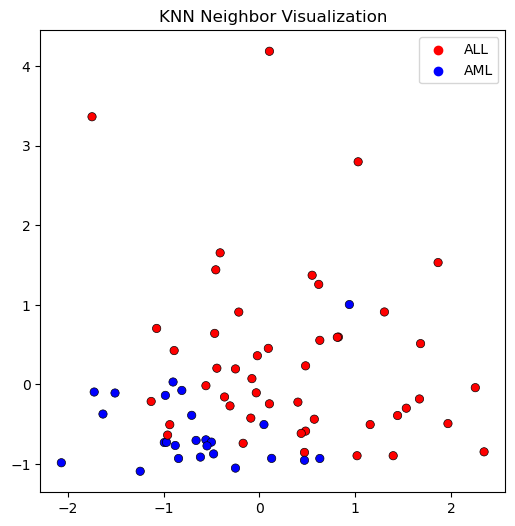

In [137]:
test_index = 5
test_point = X[test_index].reshape(1, -1)

# Plot data
plt.figure(figsize=(6,6))
sns.scatterplot(x=Xarray[:, 0], y=Xarray[:, 1], hue=y, palette=["red", "blue"], edgecolor="k")
plt.legend()
plt.title("KNN Neighbor Visualization")
plt.show()

In [82]:
from sklearn.decomposition import PCA

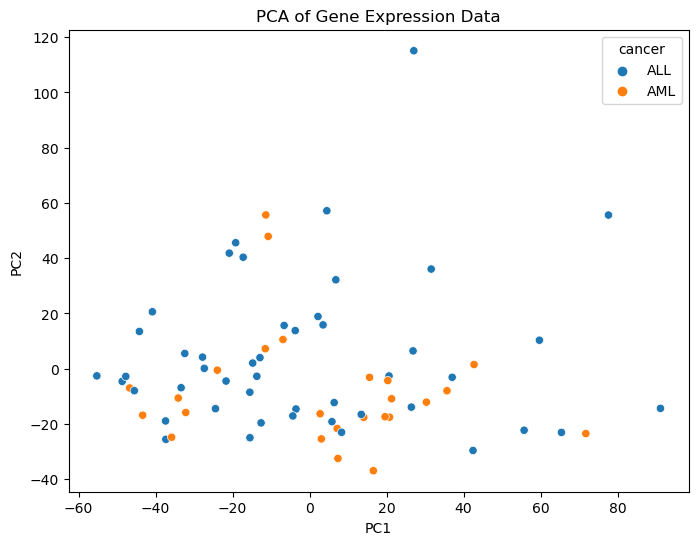

In [88]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(mergedXY_norm.iloc[:,:mergedXY.shape[1]-2])

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['cancer'] = y

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cancer', data=pca_df)
plt.title('PCA of Gene Expression Data')
plt.show()

Using the entire data set, KNN model prediction accuracy for cancer class was ~82% whereas in the Golub et al 1999 paper,  85%.

## References
1. https://pubmed.ncbi.nlm.nih.gov/10521349/
2. https://academic.oup.com/bioinformatics/article/18/7/961/256591?login=false